In [66]:
import numpy as np
train_set = np.load('../data/HG002_2_3_00_400k_train.npz')
train_set.files

['features', 'labels', 'read_ids']

In [67]:
test_set = np.load('../data/HG002_2_3_00_400k_test.npz')
test_set.files

['features', 'labels', 'read_ids']

In [68]:
features = train_set['features']
features.shape

(256000, 6, 15)

In [69]:
features[0]

# ACGT, base quality, m6a score (dorado output normalized)
# left to right (7 before - central - 7 after)
# 7 or less

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ],
       [1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        1.        , 1.        , 0.        , 1.        , 1.        ],
       [0.16078431, 0.17647059, 0.16078431, 0.16078431, 0.19607843,
        0.15686275, 0.15686275, 0.19607843, 0.19607843, 0.15686275,
        0.16470588, 0.19607843, 0.15294118, 

In [70]:
# compare base quality
print(np.min(features[:, 4, :]))
print(np.max(features[:, 4, :]))

0.00392156862745098
0.19607843137254902


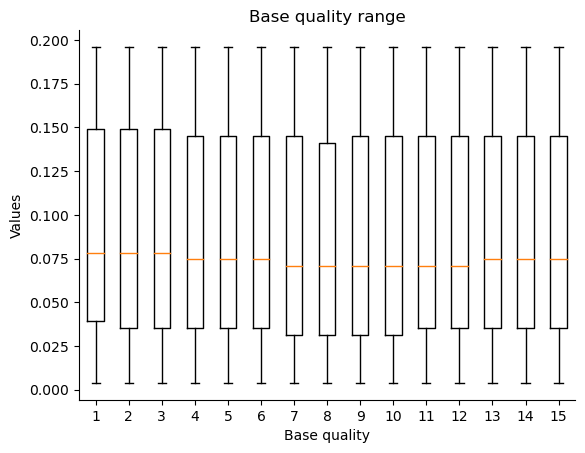

In [71]:
import matplotlib.pyplot as plt

data_to_plot = features[:, 4, :]

plt.boxplot(data_to_plot)

plt.xlabel('Base quality')
plt.ylabel('Values')
plt.title('Base quality range')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [72]:
above_threshold_mask = features[:, 4, :] > 0.05
all_above_threshold = np.all(above_threshold_mask, axis=1)
np.sum(all_above_threshold)

121907

In [73]:
2616972/5120000 * 100

51.112734375

In [74]:
labels = train_set['labels']
labels.shape

(256000,)

In [75]:
np.unique(labels, return_counts=True)
# balanced dataset

(array([0, 1], dtype=int64), array([128000, 128000], dtype=int64))

In [76]:
read_ids = train_set['read_ids']
read_ids.shape

(256000,)

In [77]:
print(len(np.unique(read_ids)))
np.unique(read_ids)

10589


array(['0010e35b-3962-44eb-84b5-f33166fd32ce',
       '001a12e3-3b0c-446a-9b5b-e5f0f6bb8a2b',
       '00267282-ee7f-4f39-b12e-3a281a4dd7ef', ...,
       'fff2267a-1ce5-4634-8323-4d181a2c754b',
       'fff4ab3e-a1db-44c3-9d33-b5052bfd5ca8',
       'ffffa7d9-dacb-42c5-a2c2-34045fdf594a'], dtype='<U36')

In [78]:
import numpy as np

# get bases loop form

def filter_set_by_base_quality(data, quality_threshold=0.05, drop_base_quality=True):
    features = data['features']
    labels = data['labels']
    import numpy as np

    list_above_threshold = []
    
    for i in range(features.shape[0]):
        if features[i, 4, 7] > quality_threshold:
            list_above_threshold.append(i)
    
    above_threshold_indices = np.array(list_above_threshold)
    
    above_threshold_features = features[above_threshold_indices]
    above_threshold_labels = labels[above_threshold_indices]
    
    if drop_base_quality:
        above_threshold_features = above_threshold_features[:, np.arange(above_threshold_features.shape[1]) != 4, :]
    
    return above_threshold_features, above_threshold_labels

filtered_features, filtered_labels = filter_set_by_base_quality(train_set)


# vectorized version

# def filter_set_by_base_quality(data, quality_threshold=0.05, drop_base_quality=True):
#     features = data['features']
#     labels = data['labels']

#     above_threshold_mask = features[:, 4, :] > quality_threshold
#     all_above_threshold_features = features[:, above_threshold_mask, :]

#     all_above_threshold_indices = np.where(all_above_threshold_features)[0]


#     if drop_base_quality:
#         mask = np.arange(features.shape[1]) != 4
#         all_above_threshold_features = all_above_threshold_features[:, mask, :]

    
#     print(len(all_above_threshold_indices))
    
#     all_above_threshold_labels = labels[all_above_threshold_indices]

#     return all_above_threshold_features, all_above_threshold_labels


In [79]:
print(len(filtered_features) == len(filtered_labels))
print(filtered_features.shape)
len(filtered_features) / len(train_set['features']) * 100

True
(163831, 5, 15)


63.996484374999994

In [80]:
def set_num_nucleotides(features, num = 5):
    if num > 7:
        print('Cannot have more than 7 nucleotides.')
    else:
        num_to_remove = 7 - num
        
        keep_from_start = num_to_remove
        keep_from_end = features.shape[2] - num_to_remove

        new_features = features[:, :, keep_from_start:keep_from_end]
        
        return new_features

filtered_features = set_num_nucleotides(filtered_features, 5)
filtered_features.shape

(163831, 5, 11)

c:\Users\Cat\anaconda3\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Cat\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


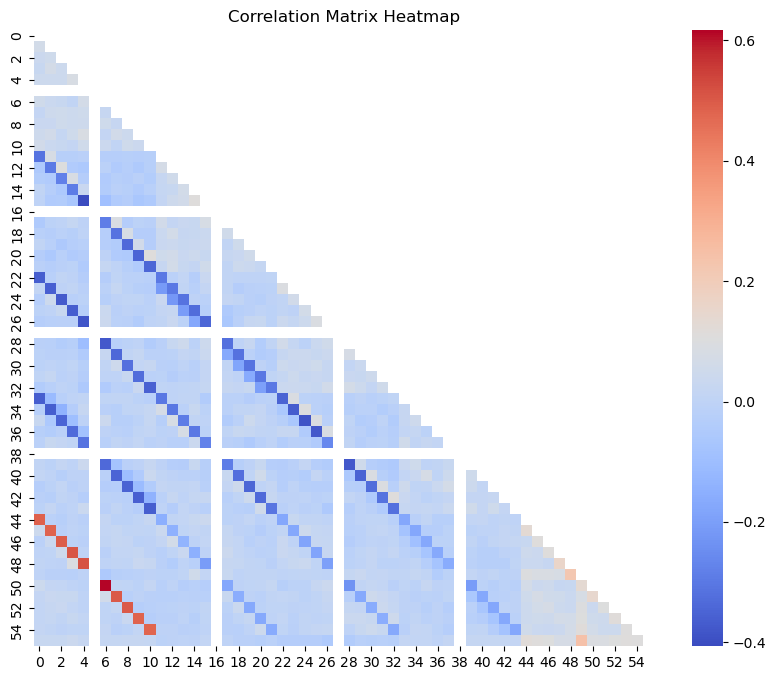

In [104]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

original_shape = filtered_features.shape

# reformat features into 2D and add label
corr_matrix_data = filtered_features.reshape(original_shape[0], -1)
filtered_labels_reshaped = filtered_labels.reshape(-1, 1)
corr_matrix_data = np.hstack((corr_matrix_data, filtered_labels_reshaped))
correlation_matrix = np.corrcoef(corr_matrix_data, rowvar=False)

# extract the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [95]:
np.unique(corr_matrix_data[:, 5])

array([1.])

In [100]:
(38 + 1) %  5

4

In [101]:
(5 + 1) %  5

1

In [103]:
(27 + 1) %  5

3

In [102]:
(16 + 1) %  5

2

In [15]:
# prep for model input

X_train = filtered_features.transpose((0, 2, 1))
y_train = filtered_labels

print(X_train.shape)

(163831, 11, 5)


In [40]:
# test data

test_filtered_features, test_filtered_labels = filter_set_by_base_quality(train_set)
test_filtered_features = set_num_nucleotides(test_filtered_features, 5)

X_test = test_filtered_features.transpose((0, 2, 1))
y_test = test_filtered_labels

In [18]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)


131064

### LSTM benchmark

In [20]:
# basic lstm architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(11, 5)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

epochs = 10

for epoch in range(epochs):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32)
    
    train_loss_history.append(history.history['loss'])
    train_accuracy_history.append(history.history['accuracy'])
    val_loss_history.append(history.history['val_loss'])
    val_accuracy_history.append(history.history['val_accuracy'])
    
    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {history.history['loss'][0]:.4f}, "
          f"Train Acc: {history.history['accuracy'][0]:.4f}, "
          f"Val Loss: {history.history['val_loss'][0]:.4f}, "
          f"Val Acc: {history.history['val_accuracy'][0]:.4f}")

4096/4096 [==============================] - 35s 8ms/step - loss: 0.6198 - accuracy: 0.6646 - val_loss: 0.6036 - val_accuracy: 0.6804
Epoch 1/10 - Train Loss: 0.6198, Train Acc: 0.6646, Val Loss: 0.6036, Val Acc: 0.6804
4096/4096 [==============================] - 32s 8ms/step - loss: 0.6020 - accuracy: 0.6762 - val_loss: 0.5943 - val_accuracy: 0.6853
Epoch 2/10 - Train Loss: 0.6020, Train Acc: 0.6762, Val Loss: 0.5943, Val Acc: 0.6853
4096/4096 [==============================] - 31s 8ms/step - loss: 0.5984 - accuracy: 0.6792 - val_loss: 0.5965 - val_accuracy: 0.6840
Epoch 3/10 - Train Loss: 0.5984, Train Acc: 0.6792, Val Loss: 0.5965, Val Acc: 0.6840
4096/4096 [==============================] - 33s 8ms/step - loss: 0.5962 - accuracy: 0.6799 - val_loss: 0.5956 - val_accuracy: 0.6856
Epoch 4/10 - Train Loss: 0.5962, Train Acc: 0.6799, Val Loss: 0.5956, Val Acc: 0.6856
4096/4096 [==============================] - 32s 8ms/step - loss: 0.5950 - accuracy: 0.6815 - val_loss: 0.5902 - val_acc

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17985 (70.25 KB)
Trainable params: 17985 (70.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
# Five input features and eleven time steps, so we have eleven sets of input and 
# recurrent weights for each of the five features at each time step.

lstm_layer = model.layers[0] 

weights = lstm_layer.get_weights()

input_weights = weights[0]
print("Input Weights Shape:", input_weights.shape)

# Recurrent weights
recurrent_weights = weights[1]
print("Recurrent Weights Shape:", recurrent_weights.shape)


Input Weights Shape: (5, 256)
Recurrent Weights Shape: (64, 256)


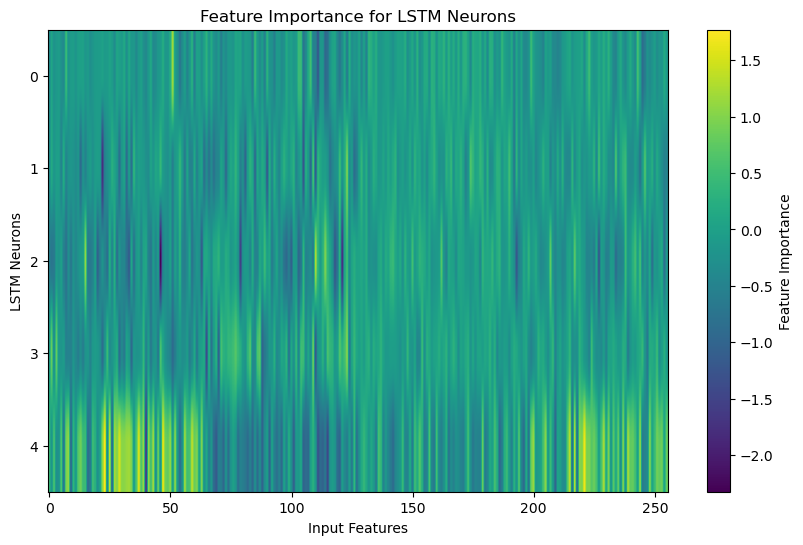

In [61]:
import matplotlib.pyplot as plt

input_feature_importance = input_weights  # transpose for easier visualization

plt.figure(figsize=(10, 6))
plt.imshow(input_feature_importance, cmap='viridis', aspect='auto')
plt.colorbar(label='Feature Importance')
plt.ylabel('Input Features')
plt.xlabel('LSTM Neurons')
plt.title('Feature Importance for LSTM Neurons')
plt.show()


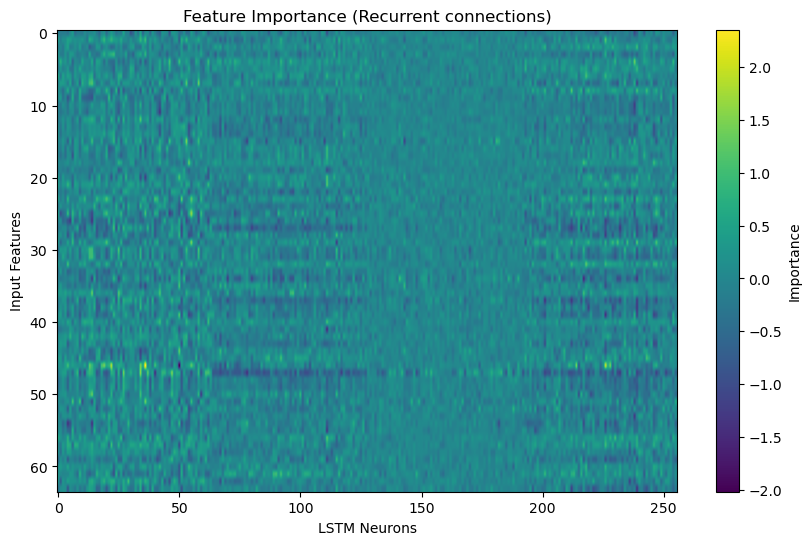

In [64]:
import matplotlib.pyplot as plt

input_feature_importance = recurrent_weights  # transpose for easier visualization

plt.figure(figsize=(10, 6))
plt.imshow(input_feature_importance, cmap='viridis', aspect='auto')
plt.colorbar(label='Importance')
plt.ylabel('Input Features')
plt.xlabel('LSTM Neurons')
plt.title('Feature Importance (Recurrent connections)')
plt.show()


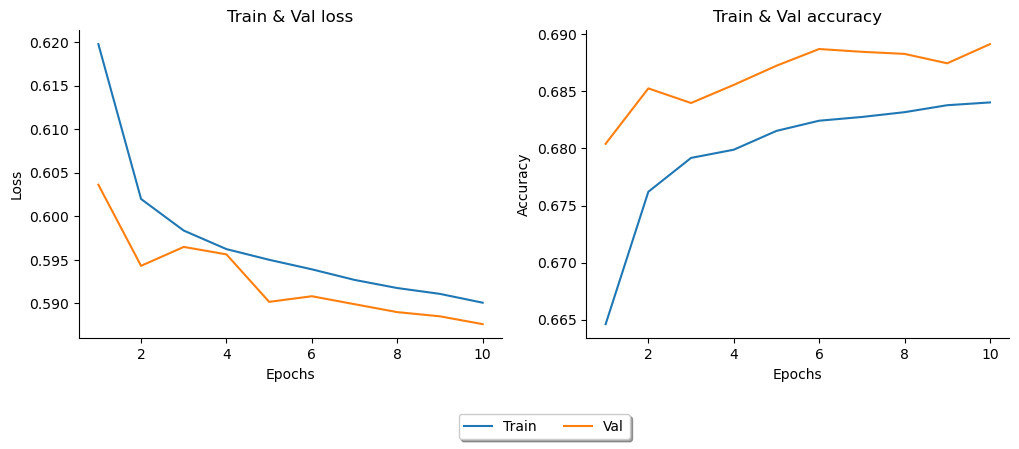

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Train & Val loss')
plt.plot(range(1, epochs + 1), train_loss_history, label='Train')
plt.plot(range(1, epochs + 1), val_loss_history,label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplot(1, 2, 2)
plt.title('Train & Val accuracy')
plt.plot(range(1, epochs + 1), train_accuracy_history, label='Train')
plt.plot(range(1, epochs + 1), val_accuracy_history, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.35), fancybox=True, shadow=True, ncol=2)

plt.show()

In [43]:
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.5).astype(int)

5120/5120 [==============================] - 17s 3ms/step


In [44]:
np.unique(binary_predictions, return_counts=True)

(array([0, 1]), array([129271,  34560], dtype=int64))

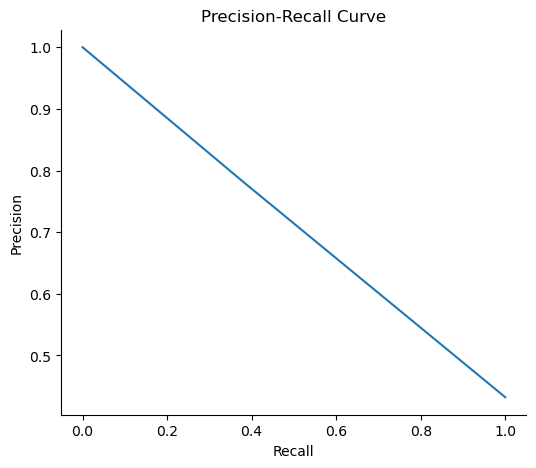

In [106]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, binary_predictions)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

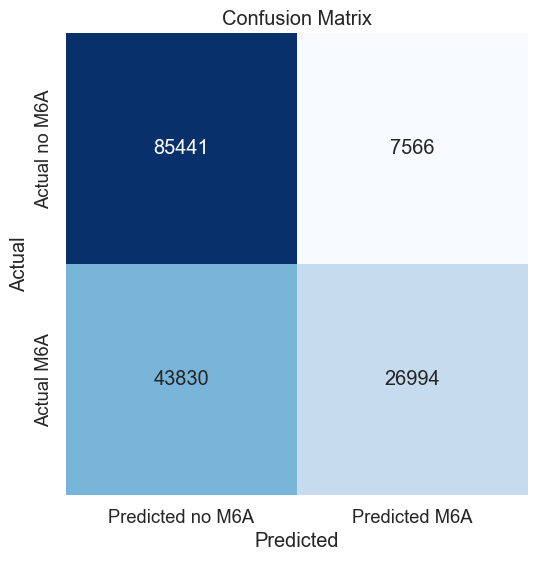

In [107]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, binary_predictions)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=["Predicted no M6A", "Predicted M6A"],
            yticklabels=["Actual no M6A", "Actual M6A"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Hparam search & more LSTM-CNN hybrid architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, input_shape=(11, 5)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

epochs = 10

for epoch in range(epochs):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32)
    
    train_loss_history.append(history.history['loss'])
    train_accuracy_history.append(history.history['accuracy'])
    val_loss_history.append(history.history['val_loss'])
    val_accuracy_history.append(history.history['val_accuracy'])
    
    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {history.history['loss'][0]:.4f}, "
          f"Train Acc: {history.history['accuracy'][0]:.4f}, "
          f"Val Loss: {history.history['val_loss'][0]:.4f}, "
          f"Val Acc: {history.history['val_accuracy'][0]:.4f}")